### This aims to classify the exosome status based on a featureset derrived from the peaks.

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from scipy.integrate import trapz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


Locate and correct the spikes

In [5]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

Carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [6]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

lam = 10 ** 3
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [7]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order))

Scale the absorbances of each spectra by the max value.

In [8]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

Try Min Max Scaling

## 1 Sample Example

In [9]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Despiked_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [10]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

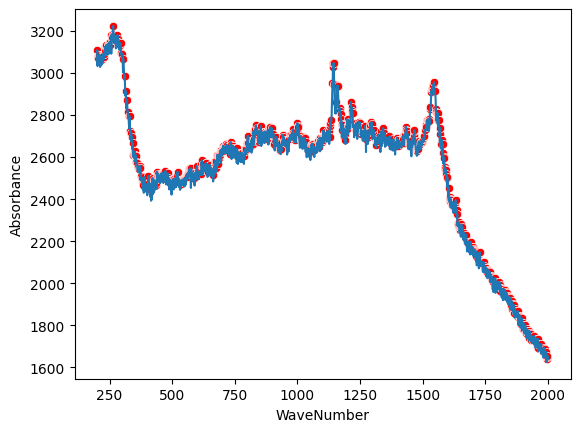

In [11]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

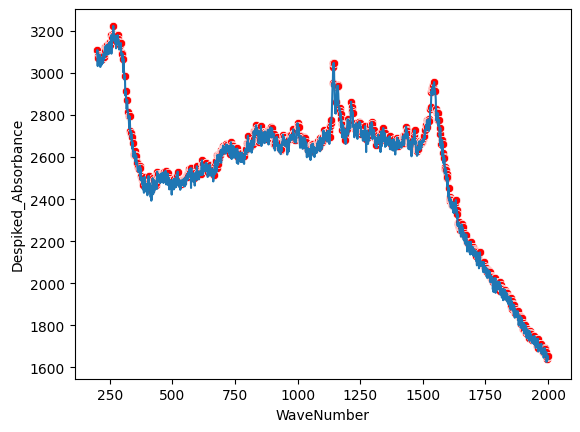

In [12]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

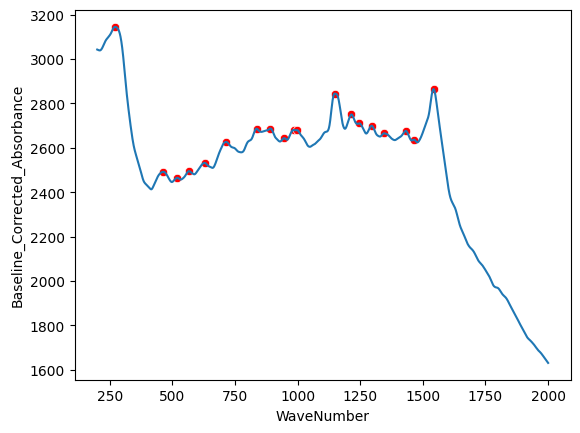

In [13]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

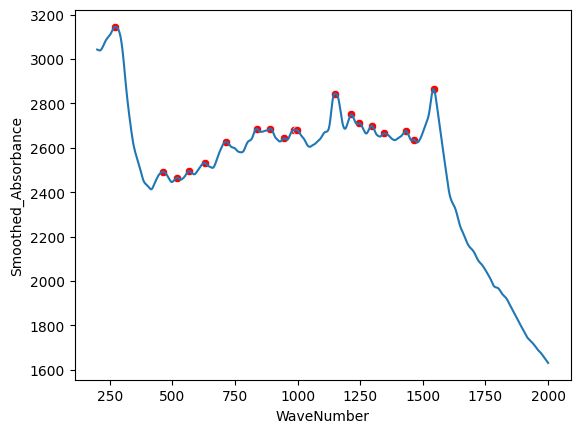

In [14]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

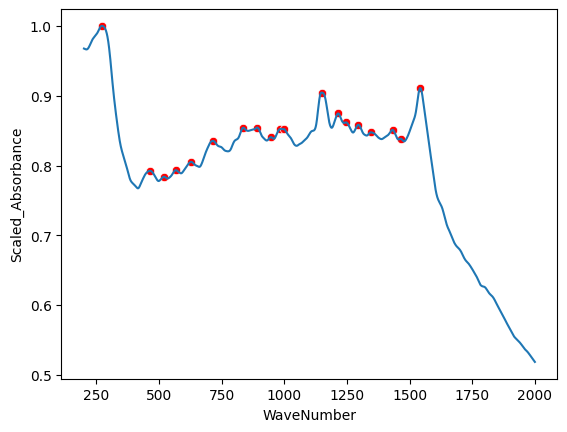

In [15]:
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[normalised_peaks], x="WaveNumber", y="Scaled_Absorbance", color="red")

The average baseline corrected spectrum of each status

<AxesSubplot: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

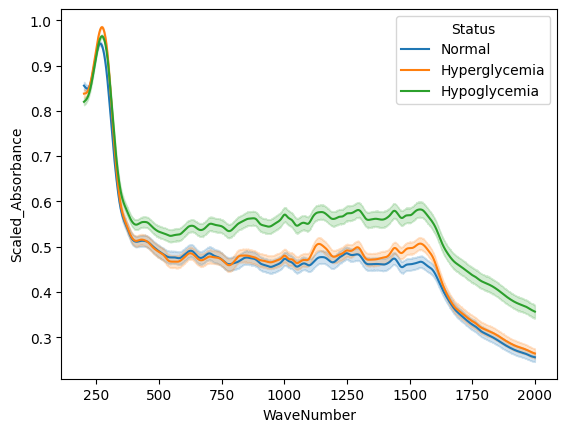

In [16]:
sns.lineplot(data=df, x='WaveNumber', y='Scaled_Absorbance', hue='Status')

#### Machine Learning

In [17]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [18]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [19]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [20]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [21]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.998435,0.996880,0.995333,0.993794,0.992259,0.990735,0.989228,0.987741,0.986277,...,0.404450,0.404232,0.404023,0.403821,0.403623,0.403425,0.403231,0.403040,0.402852,Normal
201210-1-01,1.000000,0.997784,0.995571,0.993362,0.991156,0.988951,0.986752,0.984558,0.982372,0.980197,...,0.423986,0.424210,0.424442,0.424680,0.424923,0.425165,0.425411,0.425659,0.425911,Normal
201210-1-02,1.000000,0.997002,0.994016,0.991044,0.988084,0.985128,0.982189,0.979273,0.976385,0.973533,...,0.568881,0.570079,0.571272,0.572461,0.573646,0.574831,0.576013,0.577192,0.578369,Normal
201210-1-03,0.741209,0.758076,0.774771,0.791293,0.807643,0.823983,0.840069,0.855790,0.871042,0.885727,...,0.195789,0.195683,0.195578,0.195474,0.195370,0.195266,0.195161,0.195057,0.194953,Normal
201210-1-04,1.000000,0.998114,0.996231,0.994350,0.992470,0.990592,0.988716,0.986844,0.984978,0.983121,...,0.496956,0.496816,0.496688,0.496571,0.496460,0.496351,0.496247,0.496147,0.496054,Normal


##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [22]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [23]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [24]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9307 +/- 0.0149
ExtraTreesClassifier Cross-Validation Accuracy: 0.9491 +/- 0.0113


#### 2. Using Peak Statistics

This uses statistical properties of the peaks in each sample to be used as additional features.

In [36]:
x = spectra_df.copy()

Find local minima using the inverse of the spectrum.

Then use this to calculate the area under the peak.

In [70]:
x['NegativeAbsorbance'] = x['Absorbance'] * -1

In [71]:
sample = x[x['SpecID'] == "210526-3-04"]

In [72]:
peaks, _ = find_peaks(x=sample['Absorbance'])
troughs, _ = find_peaks(x=sample['NegativeAbsorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

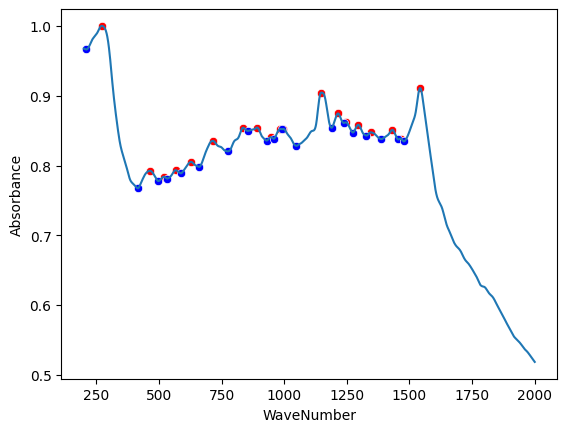

In [73]:
sns.lineplot(x="WaveNumber", y='Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")
sns.scatterplot(data=sample.iloc[troughs], x="WaveNumber", y="Absorbance", color="blue")

In [51]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

    # Use find_peaks on the inverse of the absorbance to find local minima
    inverse_absorbance = group['Absorbance'] * -1
    trough_index, _ = find_peaks(x=inverse_absorbance)

    # Calculate the areas under each peak
    for i in range(len(trough_index) - 1):
        # Determine the start and end indices for the area calculation
        start_index = peak_index[i]
        end_index = peak_index[i + 1]

        # Get the absorbance values within the peak
        absorbance_values = group['Absorbance'].iloc[start_index:end_index]

        # Calculate the x values for the area calculation
        x_values = group.index[start_index:end_index]

        # Calculate the area using the trapezoidal rule
        area = trapz(absorbance_values, x=x_values)
        areas.append(area)

peaks_df = df.iloc[peaks]

In [44]:
print(len(peaks))
print(len(widths))
print(len(prominences))
print(len(areas))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences
peaks_df['AreaUnderPeak'] = areas

60378
60378
60378


/tmp/ipykernel_18492/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_18492/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [45]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,0.482789,11.241177,0.001058
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,0.419120,20.821801,0.001594
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,0.392768,27.575649,0.004043
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,0.453877,56.889969,0.072117
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,0.452262,47.353488,0.079974


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [46]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [47]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [48]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,0.310112,0.112995,22,0.482789,0.014928,33.012231,30.964040,116.531105,4.445955,0.014643,0.024252,0.079974,6.888706e-06,Normal
201210-1-01,0.301468,0.113416,21,0.455711,0.005856,36.736149,36.131082,141.320235,0.770091,0.018883,0.027114,0.085333,8.310679e-07,Normal
201210-1-02,0.190925,0.137769,18,0.651423,0.003470,47.413053,41.633435,165.964809,4.544830,0.070486,0.147659,0.605067,5.017802e-05,Normal
201210-1-03,0.223556,0.248440,17,1.000000,0.082843,40.007533,23.074929,83.426549,6.324263,0.049184,0.082838,0.321461,4.444498e-05,Normal
201210-1-04,0.313778,0.147594,18,0.834391,0.076173,53.498900,58.207152,239.335118,5.374095,0.030498,0.050673,0.214688,6.053875e-05,Normal


In [49]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7245 +/- 0.0186
ExtraTreesClassifier Cross-Validation Accuracy: 0.7373 +/- 0.0266


Combine these peak statistics with the full wavelength

In [50]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [51]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.310112,0.112995,22,0.482789,0.014928,33.012231,30.964040,116.531105,4.445955,0.014643,...,0.003059,0.002677,0.002312,0.001961,0.001622,0.001290,0.000959,0.000634,0.000314,0.000000
201210-1-01,0.301468,0.113416,21,0.455711,0.005856,36.736149,36.131082,141.320235,0.770091,0.018883,...,0.005380,0.005754,0.006141,0.006542,0.006953,0.007371,0.007790,0.008214,0.008642,0.009076
201210-1-02,0.190925,0.137769,18,0.651423,0.003470,47.413053,41.633435,165.964809,4.544830,0.070486,...,0.095504,0.098026,0.100533,0.103029,0.105515,0.107995,0.110473,0.112946,0.115414,0.117877
201210-1-03,0.223556,0.248440,17,1.000000,0.082843,40.007533,23.074929,83.426549,6.324263,0.049184,...,0.001172,0.001039,0.000907,0.000777,0.000647,0.000518,0.000389,0.000259,0.000129,0.000000
201210-1-04,0.313778,0.147594,18,0.834391,0.076173,53.498900,58.207152,239.335118,5.374095,0.030498,...,0.002098,0.001790,0.001512,0.001259,0.001026,0.000806,0.000590,0.000383,0.000186,0.000000


In [52]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9248 +/- 0.0130
ExtraTreesClassifier Cross-Validation Accuracy: 0.9455 +/- 0.0104


#### 3. Creating a uniform Peak Featureset

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [53]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [54]:
print(len(peaks))
print(len(widths))
print(len(prominences))
print(len(areas))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences
peaks_df['AreaUnderPeak'] = areas

60378
60378
60378


/tmp/ipykernel_18492/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_18492/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [55]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,0.482789,11.241177,0.001058
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,0.419120,20.821801,0.001594
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,0.392768,27.575649,0.004043
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,0.453877,56.889969,0.072117
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,0.452262,47.353488,0.079974


Assign Peaks to bins of a fixed wavelength interval.

In [56]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_18492/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [57]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences,Bin
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,0.482789,11.241177,0.001058,350-375
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,0.419120,20.821801,0.001594,450-475
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,0.392768,27.575649,0.004043,525-550
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,0.453877,56.889969,0.072117,600-625
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,0.452262,47.353488,0.079974,675-700


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [58]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

In [59]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.369255,False,0.344623,False,False,0.308281,False,0.279086,False,0.289731,...,False,10.535987,False,10.244074,116.531105,False,False,False,False,Normal
201210-1-01,0.33951,False,0.310183,False,False,0.278832,False,0.260201,False,False,...,False,False,False,8.061369,False,114.678687,6.881845,False,False,Normal
201210-1-02,0.197949,0.2097,False,False,False,0.166989,False,False,False,False,...,False,False,False,False,False,46.47195,False,False,False,Normal
201210-1-03,False,False,0.136275,False,False,False,0.195867,False,False,0.122711,...,False,False,False,False,False,68.058547,False,False,83.426549,Normal
201210-1-04,0.264422,False,0.251858,False,False,False,False,0.293389,False,False,...,False,False,False,False,5.374095,100.717433,False,False,False,Normal


In [60]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8440 +/- 0.0126
ExtraTreesClassifier Cross-Validation Accuracy: 0.8571 +/- 0.0152


Merge with the full spectrum.

In [61]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_18492/2474809401.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [62]:
bins_and_spectrum.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.369255,False,0.344623,False,False,0.308281,False,0.279086,False,0.289731,...,0.003059,0.002677,0.002312,0.001961,0.001622,0.001290,0.000959,0.000634,0.000314,0.000000
201210-1-01,0.33951,False,0.310183,False,False,0.278832,False,0.260201,False,False,...,0.005380,0.005754,0.006141,0.006542,0.006953,0.007371,0.007790,0.008214,0.008642,0.009076
201210-1-02,0.197949,0.2097,False,False,False,0.166989,False,False,False,False,...,0.095504,0.098026,0.100533,0.103029,0.105515,0.107995,0.110473,0.112946,0.115414,0.117877
201210-1-03,False,False,0.136275,False,False,False,0.195867,False,False,0.122711,...,0.001172,0.001039,0.000907,0.000777,0.000647,0.000518,0.000389,0.000259,0.000129,0.000000
201210-1-04,0.264422,False,0.251858,False,False,False,False,0.293389,False,False,...,0.002098,0.001790,0.001512,0.001259,0.001026,0.000806,0.000590,0.000383,0.000186,0.000000


In [63]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9261 +/- 0.0090
ExtraTreesClassifier Cross-Validation Accuracy: 0.9461 +/- 0.0122


In [64]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.9261 +/- 0.0090
Top 10 Features: Index(['289.52164', '271.07062', '285.42142', '290.8884', '293.62186',
       '294.30524', '292.93851', '301.13895', '290.20502', '280.63782'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.9461 +/- 0.0122
Top 10 Features: Index(['281.3212', '283.37131', '288.83826', '287.47153', '285.42142',
       '301.82233', '291.57175', '276.5376', '299.08884', '286.1048'],
      dtype='object')


Try the raw spectrum with the baseline corrected peaks.

In [65]:
spectra_df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

#Create a field for each wavelength.
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None
#Add the statuses back.
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [66]:
raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_18492/983759271.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [67]:
# Splitting the dataframe into features (X) and target variable (y)
X = raw_spec_baseline_bins.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8923 +/- 0.0155
ExtraTreesClassifier Cross-Validation Accuracy: 0.9031 +/- 0.0144


In [68]:
raw_spec_baseline_bins.to_csv("../../data/raw_spec_and_max_bins.csv")